In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import savemat
import math
from loading_real_wave_noise import loading_real_wave_noise
from Reading_path_test import loading_paths_from_MAT
from Control_filter_selection import Control_filter_selection
from FxNLMS_algorithm import FxNLMS, train_fxnlms_algorithm
from VSS_FxNLMS_algorithm import VSS_FxNLMS, train_vss_fxnlms_algorithm
from Disturbance_generation import Disturbance_generation_from_real_noise
from Combine_SFANC_with_FxNLMS import SFANC_FxNLMS
from Combine_SFANC_with_VSS_FxNLMS import SFANC_VSS_FxNLMS

print(torch.cuda.is_available())

True


In [2]:
# real noises
fs = 16000
#StepSize = 0.0001
sound_name = 'NeighborSpeaking_1.1'
waveform, resample_rate = loading_real_wave_noise(folde_name='Real Noise Examples/', sound_name=sound_name+'.wav')
print('yeap')

yeap


In [3]:
# Pri_path, Secon_path = loading_paths_from_MAT(folder='Pz and Sz', subfolder='Dongyuan', Pri_path_file_name='Primary_path.mat', Sec_path_file_name='Secondary_path.mat')
Pri_path, Secon_path = loading_paths_from_MAT(folder='C:\PycharmProjects\SFANC-FxNLMS-ANC-Algorithm-based-on-Deep-Learning-main', subfolder='Primary and Secondary Path',Pri_path_file_name='Primary_path.mat', Sec_path_file_name='Secondary_path.mat')
Dis, Fx, Re = Disturbance_generation_from_real_noise(fs=fs, Repet=0, wave_form=waveform, Pri_path=Pri_path, Sec_path=Secon_path)
# Dis: disturbance (cotrolled noise)， Fx: fixed-x signal, Re: repeated waveform (primary_noise) Repetition=Repet+1
print('yeap')

yeap


In [4]:
print(waveform.shape)
print(Re.shape)
print(Dis.shape)

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

torch.Size([1, 160000])
torch.Size([160000])
torch.Size([160000])


[========================================================================] 100%
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



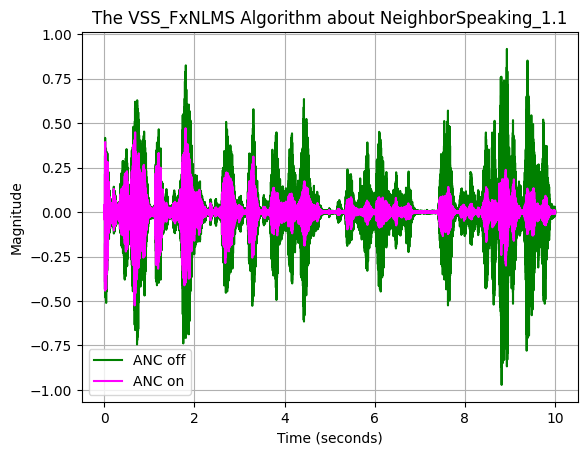

In [6]:
from sqlite3 import Time

# FxNLMS


controller = VSS_FxNLMS(Len=1024,mu_min=0.001, mu_max=0.1, beta=0.01) # 1024 is the same size of coeffient vector of fixed-filter
ErrorFxNLMS = train_vss_fxnlms_algorithm(Model=controller, Ref=Fx, Disturbance=Dis, mu_min=0.01, mu_max=0.1, beta=0.01) #训练VSS_FxNLMS模型

print(ErrorFxNLMS)
print(Dis)

# 假设 ErrorFxNLMS 是一个包含FxNLMS误差的列表或数组
ErrorFxNLMS = np.array(ErrorFxNLMS)  # 将 ErrorFxNLMS 转换为 numpy 数组

# 创建与 ErrorFxNLMS 长度相同的时间序列
start_time = 0  # 开始时间
end_time = 10 # 结束时间 要修改
lenth = 160000
time_sequence = torch.linspace(start_time, end_time, steps=lenth)

plt.title('The VSS_FxNLMS Algorithm about NeighborSpeaking_1.1')
plt.plot(time_sequence, Dis, color='green', label='ANC off')
plt.plot(time_sequence, ErrorFxNLMS, color='magenta', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
# plt.savefig('./pdf/VSS_FxNLMS_NeighborSpeaking_1.1.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# plt.title('The FxNLMS Algorithm')
# array_1 = list(range(1, 368001)) #----------------
# plt.plot(Time, Dis, color='blue', label='ANC off')
# # plt.plot(array_1, Dis, color='blue', label='ANC off')
# # plt.plot(array_1, ErrorFxNLMS, color='green', label='ANC on')
# plt.plot(Time, ErrorFxNLMS, color='green', label='ANC on')
# plt.ylabel('Magnitude')
# plt.xlabel('Time (seconds)')
# plt.legend()
# plt.grid()
# plt.savefig('FxNLMS.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()

The primary nosie has 10 seconds !!!
[11, 11, 7, 11, 7, 7, 7, 7, 11, 11]


C:\PycharmProjects\SFANC-FxNLMS-ANC-Algorithm-based-on-Deep-Learning-main\Combine_SFANC_with_VSS_FxNLMS.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Wc = torch.tensor(Ws, requires_grad=True)  # 初始化的Wc是全0 可以优化


0
change the initial weights of VSS_FxNLMS
1
2
change the initial weights of VSS_FxNLMS
3
change the initial weights of VSS_FxNLMS
4
change the initial weights of VSS_FxNLMS
5
6
7
8
change the initial weights of VSS_FxNLMS
9


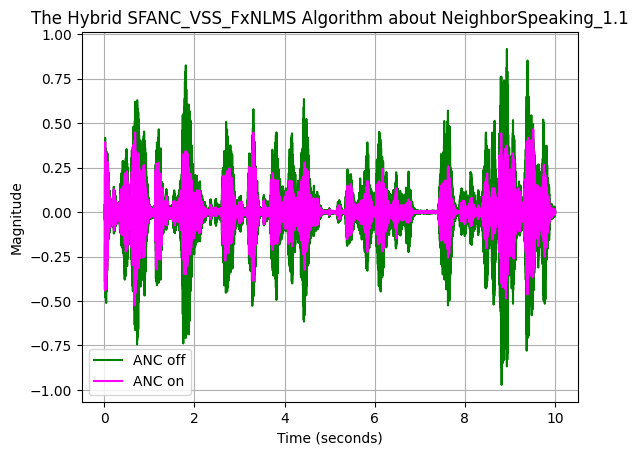

In [7]:
# Combine SFANC with VSS_FxNLMS

# prediction index
id_vector = Control_filter_selection(fs=16000, Primary_noise=Re.unsqueeze(0)) # Primary_noise: torch.Size([1, XX])
print(id_vector) #这个本身含有预测

# Using prediction index in SFANC_VSS_FxNLMS
FILE_NAME_PATH = 'Trained models/Pretrained_Control_filters.mat'
SFANC_VSS_FxNLMS_Cancellation = SFANC_VSS_FxNLMS(MAT_FILE=FILE_NAME_PATH, fs=16000) #又来一个预测
Error_SFANC_VSS_FxNLMS = SFANC_VSS_FxNLMS_Cancellation.noise_cancellation(Dis=Dis, Fx=Fx, filter_index=id_vector, mu_min=0.01, mu_max=0.1, beta=0.01)

plt.title('The Hybrid SFANC_VSS_FxNLMS Algorithm about NeighborSpeaking_1.1')
plt.plot(time_sequence, Dis, color='green', label='ANC off')
plt.plot(time_sequence, Error_SFANC_VSS_FxNLMS, color='magenta', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
# plt.savefig('./pdf/SFANC_VSS_FxNLMS_NeighborSpeaking_1.1.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()